<a href="https://colab.research.google.com/github/kahramanmurat/stock-markets-analytics-zoomcamp-2024/blob/main/02-dataframe-analysis/homework/Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install yfinance

In [62]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt



---
### Question 1: IPO Filings Web Scraping and Data Processing

**What's the total sum ($m) of 2023 filings that happened on Fridays?**

Re-use the [Code Snippet 1] example to get the data from web for this endpoint: https://stockanalysis.com/ipos/filings/
Convert the 'Filing Date' to datetime(), 'Shares Offered' to float64 (if '-' is encountered, populate with NaNs).
Define a new field 'Avg_price' based on the "Price Range", which equals to NaN if no price is specified, to the price (if only one number is provided), or to the average of 2 prices (if a range is given).
You may be inspired by the function `extract_numbers()` in [Code Snippet 4], or you can write your own function to "parse" a string.
Define a column "Shares_offered_value", which equals to "Shares Offered" * "Avg_price" (when both columns are defined; otherwise, it's NaN)

Find the total sum in $m (millions of USD, closest INTEGER number) for all filings during 2023, which happened on Fridays (`Date.dt.dayofweek()==4`). You should see 32 records in total, 25 of it is not null.

(additional: you can read about [S-1 IPO filing](https://www.dfinsolutions.com/knowledge-hub/thought-leadership/knowledge-resources/what-s-1-ipo-filing) to understand the context)

---

In [63]:
import pandas as pd
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/filings/"
response = requests.get(url, headers=headers)

ipos_df = pd.read_html(response.text)

In [64]:
ipos_df = ipos_df[0]
ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Filing Date     326 non-null    object
 1   Symbol          326 non-null    object
 2   Company Name    326 non-null    object
 3   Price Range     326 non-null    object
 4   Shares Offered  326 non-null    object
dtypes: object(5)
memory usage: 12.9+ KB


In [65]:
# convert to datetime
ipos_df['Filing Date'] = pd.to_datetime(ipos_df['Filing Date'], format='%b %d, %Y')

In [66]:
ipos_df['Shares Offered'] = pd.to_numeric(ipos_df['Shares Offered'], errors='coerce')

In [67]:
import pandas as pd
import numpy as np

# Function to parse the price range and calculate the average
def calculate_average_price(price_range):
    # Handle cases where the cell might be empty or contain a dash
    if price_range.strip() == '-' or not price_range.strip():
        return np.nan
    # Remove the dollar sign and split by '-'
    parts = price_range.replace('$', '').split('-')
    # Convert parts to numeric, wrapped in a pandas Series
    numbers = pd.Series(pd.to_numeric(parts, errors='coerce'))
    # Filter out NaN values and compute the mean if any numbers are present
    valid_numbers = numbers.dropna()
    if valid_numbers.empty:
        return np.nan
    else:
        return valid_numbers.mean()

# Assuming ipos_df is your DataFrame and 'Price Range' is a column in it
# Apply the function to create the 'Average Price' column
ipos_df['Average Price'] = ipos_df['Price Range'].apply(calculate_average_price)

In [68]:
# Assuming 'ipos_df' is your DataFrame and it already contains 'Shares Offered' and 'Average Price' columns
ipos_df['Shares_offered_value'] = ipos_df['Shares Offered'] * ipos_df['Average Price']

In [69]:
# Filter rows where the filing date is on a Friday and in the year 2023
friday_filings = ipos_df[(ipos_df['Filing Date'].dt.dayofweek == 4) & (ipos_df['Filing Date'].dt.year == 2023)]

# Sum the 'Shares_offered_value' column
total_value = friday_filings['Shares_offered_value'].sum()

# Convert the total sum to millions of USD and round to the nearest integer
total_value_millions = round(total_value / 1e6)

# Display the result
print(f"Total value in millions of USD for all Friday filings during 2023: {total_value_millions} million USD")


Total value in millions of USD for all Friday filings during 2023: 286 million USD


In [70]:
friday_filings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 50 to 166
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Filing Date           32 non-null     datetime64[ns]
 1   Symbol                32 non-null     object        
 2   Company Name          32 non-null     object        
 3   Price Range           32 non-null     object        
 4   Shares Offered        25 non-null     float64       
 5   Average Price         25 non-null     float64       
 6   Shares_offered_value  25 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 2.0+ KB


---
### Question 2:  IPOs "Fixed days hold" strategy


**Find the optimal number of days X (between 1 and 30), where 75% quantile growth is the highest?**


Reuse [Code Snippet 1] to retrieve the list of IPOs from 2023 and 2024 (from URLs: https://stockanalysis.com/ipos/2023/ and https://stockanalysis.com/ipos/2024/).
Get all OHLCV daily prices for all stocks with an "IPO date" before March 1, 2024 ("< 2024-03-01") - 184 tickers (without 'RYZB'). Please remove 'RYZB', as it is no longer available on Yahoo Finance.

Sometimes you may need to adjust the symbol name (e.g., 'IBAC' on stockanalysis.com -> 'IBACU' on Yahoo Finance) to locate OHLCV prices for all stocks. Also, you can see the ticker changes using this [link](https://stockanalysis.com/actions/changes/).
Some of the tickers (like 'DYCQ' and 'LEGT') were on the market less than 30 days (11 and 21 days, respectively). Let's leave them in the dataset; it just means that you couldn't hold them for more days than they were listed.

Let's assume you managed to buy a new stock (listed on IPO) on the first day at the [Adj Close] price]. Your strategy is to hold for exactly X full days (where X is between 1 and 30) and sell at the "Adj. Close" price in X days (e.g., if X=1, you sell on the next day).
Find X, when the 75% quantile growth (among 185 investments) is the highest.

HINTs:
* You can generate 30 additional columns: growth_future_1d ... growth_future_30d, join that with the table of min_dates (first day when each stock has data on Yahoo Finance), and perform vector operations on the resulting dataset.
* You can use the `DataFrame.describe()` function to get mean, min, max, 25-50-75% quantiles.


Additional:
* You can also ensure that the mean and 50th percentile (median) investment returns are negative for most X values, implying a wager for a "lucky" investor who might be in the top 25%.
* What's your recommendation: Do you suggest pursuing this strategy for an optimal X?


---

In [71]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/2023/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

In [72]:
ipos_2023 = ipo_dfs[0]
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      154 non-null    object
 1   Symbol        154 non-null    object
 2   Company Name  154 non-null    object
 3   IPO Price     154 non-null    object
 4   Current       154 non-null    object
 5   Return        154 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [73]:
url = "https://stockanalysis.com/ipos/2024/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

In [74]:
ipos_2024 = ipo_dfs[0]
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      65 non-null     object
 1   Symbol        65 non-null     object
 2   Company Name  65 non-null     object
 3   IPO Price     65 non-null     object
 4   Current       65 non-null     object
 5   Return        65 non-null     object
dtypes: object(6)
memory usage: 3.2+ KB


In [75]:
# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2024, ipos_2023], ignore_index=True)

In [76]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"May 8, 2024",NNE,Nano Nuclear Energy Inc.,$4.00,$5.19,29.75%


In [77]:
# Need to convert everything to a proper type (date, str, int, float, etc.)
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      219 non-null    object
 1   Symbol        219 non-null    object
 2   Company Name  219 non-null    object
 3   IPO Price     219 non-null    object
 4   Current       219 non-null    object
 5   Return        219 non-null    object
dtypes: object(6)
memory usage: 10.4+ KB


In [78]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format='%b %d, %Y')

In [79]:
stacked_ipos_df=stacked_ipos_df[(stacked_ipos_df['IPO Date'] < "2024-03-01") & (stacked_ipos_df['Symbol']!="RYZB")]

In [80]:
stacked_ipos_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
34,2024-02-27,SMXT,"SolarMax Technology, Inc.",$4.00,$10.69,167.25%
35,2024-02-22,VHAI,Vocodia Holdings Corp,$4.25,$0.14,-96.66%
36,2024-02-21,DYCQ,DT Cloud Acquisition Corporation,$10.00,$10.16,1.60%
37,2024-02-16,CHRO,Chromocell Therapeutics Corp,$6.00,$1.75,-70.83%
38,2024-02-14,UMAC,"Unusual Machines, Inc.",$4.00,$1.08,-73.00%
...,...,...,...,...,...,...
214,2023-01-25,QSG,QuantaSing Group Ltd,$12.50,$3.01,-75.92%
215,2023-01-20,CVKD,"Cadrenal Therapeutics, Inc.",$5.00,$0.49,-90.19%
216,2023-01-13,SKWD,"Skyward Specialty Insurance Group, Inc.",$15.00,$37.16,147.73%
217,2023-01-13,ISRL,Israel Acquisitions Corp,$10.00,$10.93,9.30%


In [81]:
missing_prices_df = stacked_ipos_df[stacked_ipos_df['Current'].astype(str).str.find('-') >= 0]
missing_prices_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return


In [82]:
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')

In [83]:
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

In [84]:
# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100


In [85]:
stacked_ipos_df.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
34,2024-02-27,SMXT,"SolarMax Technology, Inc.",4.00,10.69,1.6725
35,2024-02-22,VHAI,Vocodia Holdings Corp,4.25,0.14,-0.9666
36,2024-02-21,DYCQ,DT Cloud Acquisition Corporation,10.00,10.16,0.0160
37,2024-02-16,CHRO,Chromocell Therapeutics Corp,6.00,1.75,-0.7083
38,2024-02-14,UMAC,"Unusual Machines, Inc.",4.00,1.08,-0.7300


In [86]:
import pandas as pd
import yfinance as yf



df = stacked_ipos_df

# Function to fetch historical data taking into account only weekdays
def fetch_historical_prices(symbol, ipo_date):
    try:
        start_date = pd.to_datetime(ipo_date)
        # Calculate end date considering only business days (weekdays)
        end_date = max(pd.bdate_range(start=start_date, periods=30))
        stock_data = yf.download(symbol, start=start_date, end=end_date)
        if stock_data.empty:
            # Fetch maximum data available if no data found in the specific range
            stock_data = yf.download(symbol, period="max")
            # Ensure we only consider data up to the intended end_date
            stock_data = stock_data[stock_data.index <= end_date]
        return stock_data['Adj Close']
    except Exception as e:
        print(f"Failed to fetch data for {symbol}: {e}")
        return pd.Series([])  # Return an empty series in case of failure

# Generate future growth columns
for i in range(1, 31):
    df[f'growth_future_{i}d'] = None  # Initialize column

for index, row in df.iterrows():
    prices = fetch_historical_prices(row['Symbol'], row['IPO Date'])
    ipo_price = row['IPO Price']
    valid_days = pd.bdate_range(start=pd.to_datetime(row['IPO Date']), periods=31)[1:]  # Excluding IPO day
    for day in range(1, len(valid_days)+1):
        if valid_days[day-1] in prices.index:
            df.at[index, f'growth_future_{day}d'] = prices.loc[valid_days[day-1]] / ipo_price - 1

# Convert growth columns to numeric and handle NaNs
growth_columns = [f'growth_future_{i}d' for i in range(1, 31)]
df[growth_columns] = df[growth_columns].apply(pd.to_numeric, errors='coerce')  # Ensure all data is numeric
quantiles = df[growth_columns].quantile(0.75).dropna()

# Analyze the results, ensuring non-empty and valid data
if not quantiles.empty and quantiles.notna().any():
    optimal_x = quantiles.idxmax()
    highest_quantile_growth = quantiles.max()
    print(f"The optimal X is {optimal_x} with the highest 75% quantile growth of {highest_quantile_growth:.2%}")
else:
    print("No valid data available for analysis.")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DYCQ']: Exception("%ticker%: Data doesn't exist for startDate = 1708491600, endDate = 1712030400")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[********************

The optimal X is growth_future_22d with the highest 75% quantile growth of 16.92%


In [87]:
df.describe()

,IPO Date,IPO Price,Current,Return,growth_future_1d,growth_future_2d,growth_future_3d,growth_future_4d,growth_future_5d,growth_future_6d,...,growth_future_21d,growth_future_22d,growth_future_23d,growth_future_24d,growth_future_25d,growth_future_26d,growth_future_27d,growth_future_28d,growth_future_29d,growth_future_30d
count,184,184.000000,184.000000,183.000000,138.000000,140.000000,138.000000,142.000000,145.000000,141.000000,...,145.000000,149.000000,152.000000,150.000000,153.000000,148.000000,149.000000,154.000000,0.0,0.0
mean,2023-08-01 01:57:23.478260992,10.449076,9.865217,-0.247183,1.907180,1.594555,0.799997,1.092182,1.208095,1.212553,...,0.706043,0.690793,0.657151,0.631145,0.578081,0.586490,0.184072,0.496064,NaN,NaN
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999600,-0.950413,-0.952188,-0.953437,-0.953125,-0.954438,-0.953250,...,-0.953875,-0.955313,-0.952312,-0.940000,-0.963250,-0.965625,-0.965000,-0.964375,NaN,NaN
25%,2023-04-04 00:00:00,4.000000,1.197500,-0.742250,-0.186693,-0.252708,-0.257647,-0.301314,-0.351176,-0.396000,...,-0.478333,-0.476000,-0.496912,-0.492316,-0.490667,-0.501750,-0.483333,-0.510000,NaN,NaN
50%,2023-07-26 12:00:00,8.000000,5.545000,-0.410000,-0.019083,-0.049545,-0.031364,-0.030087,-0.035209,-0.079567,...,-0.075000,-0.072500,-0.084953,-0.073154,-0.096429,-0.097770,-0.101395,-0.108359,NaN,NaN
75%,2023-11-11 00:00:00,12.000000,10.780000,0.050150,0.145500,0.123714,0.142776,0.130094,0.130000,0.149231,...,0.152733,0.169231,0.126703,0.162949,0.126154,0.157771,0.114375,0.163822,NaN,NaN
max,2024-02-27 00:00:00,92.000000,118.270000,2.672500,129.500000,116.250000,91.833333,66.833333,88.666667,112.166667,...,62.500000,62.500000,64.333333,60.333333,57.333333,56.500000,27.500000,53.500000,NaN,NaN
std,NaN,9.894117,15.360084,0.647964,13.720503,11.923929,7.951715,8.011450,9.311367,10.240360,...,5.962238,5.834270,5.903538,5.552114,5.293907,5.229607,2.387430,4.826005,NaN,NaN


---
### Question 3: Is Growth Concentrated in the Largest Stocks?

**Get the share of days (percentage as int) when Large Stocks outperform (growth_7d - growth over 7 periods back) the Largest stocks?**


Reuse [Code Snippet 5] to obtain OHLCV stats for 33 stocks
for 10 full years of data (2014-01-01 to 2023-12-31). You'll need to download slightly more data (7 periods before 2014-01-01 to calculate the growth_7d for the first 6 days correctly):

`US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']`

`EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']`

`INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']`

`LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS`
<br/>

Now let's add the top 12-22 stocks (as of end-April 2024):
<br/>

`NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']`

`NEW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']`

`NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']`

`LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA`

You should be able to obtain stats for 33 LARGEST STOCKS and 32 LARGE STOCKS (from the actual stats on Yahoo Finance)

Calculate  `growth_7d` for every stock and every day.
Get the average daily `growth_7d` for the LARGEST_STOCKS group vs. the LARGE_STOCKS group.

For example, for the first of data you should have:
| Date   |      ticker_category      |  growth_7d |
|----------|:-------------:|------:|
| 2014-01-01 |  LARGE | 1.011684 |
| 2014-01-01 |   LARGEST   |   1.011797 |

On that day, the LARGEST group was growing faster than LARGE one (new stocks).

Calculate the number of days when the LARGE GROUP (new smaller stocks) outperforms the LARGEST GROUP, divide it by the total number of trading days (which should be 2595 days), and convert it to a percentage (closest INTEGER value). For example, if you find that 1700 out of 2595 days meet this condition, it means that 1700/2595 = 0.655, or approximately 66% of days, the LARGE stocks were growing faster than the LARGEST ones. This suggests that you should consider extending your dataset with more stocks to seek higher growth.

HINT: you can use pandas.pivot_table() to "flatten" the table (LARGE and LARGEST growth_7d as columns)

---

In [88]:
import yfinance as yf
import pandas as pd

# Define the stock lists
LARGEST_STOCKS = [
    'MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO', 'V', 'JPM',
    'NVO', 'MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE', 'IDEXY', 'CDI.PA',
    'RELIANCE.NS', 'TCS.NS', 'HDB', 'BHARTIARTL.NS', 'IBN', 'SBIN.NS', 'LICI.NS', 'INFY', 'ITC.NS',
    'HINDUNILVR.NS', 'LT.NS'
]

NEW_US = ['TSLA', 'WMT', 'XOM', 'UNH', 'MA', 'PG', 'JNJ', 'MRK', 'HD', 'COST', 'ORCL']
NEW_EU = ['PRX.AS', 'CDI.PA', 'AIR.PA', 'SU.PA', 'ETN', 'SNY', 'BUD', 'DTE.DE', 'ALV.DE', 'MDT', 'AI.PA', 'EL.PA']
NEW_INDIA = ['BAJFINANCE.NS', 'MARUTI.NS', 'HCLTECH.NS', 'TATAMOTORS.NS', 'SUNPHARMA.NS', 'ONGC.NS', 'ADANIENT.NS', 'NTPC.NS', 'KOTAKBANK.NS', 'TITAN.NS']

LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA

# Set date range for the data download
start_date = '2013-12-24'
end_date = '2023-12-31'

# Function to download stock data
def download_stock_data(tickers):
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    return data

# Download data for both groups
largest_data = download_stock_data(LARGEST_STOCKS)
large_data = download_stock_data(LARGE_STOCKS)

# Calculate the 7-day growth for each stock and each day
def calculate_growth(data):
    return data.pct_change(7) + 1

largest_growth = calculate_growth(largest_data)
large_growth = calculate_growth(large_data)

# Average daily growth for each group
largest_daily_growth = largest_growth.mean(axis=1)
large_daily_growth = large_growth.mean(axis=1)

# Days when LARGE outperforms LARGEST
outperform_days = (large_daily_growth > largest_daily_growth).sum()

# Total number of trading days
total_days = len(largest_daily_growth)

# Calculate the percentage
percentage_outperform = (outperform_days / total_days) * 100

# Print the result
print(f"Percentage of days when LARGE stocks outperformed LARGEST stocks: {int(percentage_outperform)}%")



[*********************100%%**********************]  33 of 33 completed
[*********************100%%**********************]  33 of 33 completed


Percentage of days when LARGE stocks outperformed LARGEST stocks: 48%


---
### Question 4: Trying Another Technical Indicators strategy

**What's the total gross profit (in THOUSANDS of $) you'll get from trading on CCI (no fees assumption)?**


First, run the entire Colab to obtain the full DataFrame of data (after [Code Snippet 9]), and truncate it to the last full 10 years of data (2014-01-01 to 2023-12-31).
If you encounter any difficulties running the Colab - you can download it using this [link](https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing).

Let's assume you've learned about the awesome **CCI indicator** ([Commodity Channel Index](https://www.investopedia.com/terms/c/commoditychannelindex.asp)), and decided to use only it for your operations.

You defined the "defensive" value of a high threshould of 200, and you trade only on Fridays (`Date.dt.dayofweek()==4`).

That is, every time you see that CCI is >200 for any stock (out of those 33), you'll invest $1000 (each record when CCI>200) at Adj.Close price and hold it for 1 week (5 trading days) in order to sell at the Adj. Close price.

What's the expected gross profit (no fees) that you get in THOUSANDS $ (closest integer value) over many operations in 10 years?
One operation calculations: if you invested $1000 and received $1010 in 5 days - you add $10 to gross profit, if you received $980 - add -$20 to gross profit.
You need to sum these results over all trades (460 times in 10 years).

Additional:
  * Add an approximate fees calculation over the 460 trades from this calculator https://www.degiro.ie/fees/calculator (Product:"Shares, USA and Canada;" Amount per transaction: "1000 EUR"; Transactions per year: "460")
  * are you still profitable on those trades?


---

In [89]:
import pandas as pd
filename = 'stocks_df_combined_trunc_2014_2023.parquet.brotli'  # Use the correct date string
df = pd.read_parquet(filename, engine='pyarrow')

In [90]:
print(list(df.columns))

['Open', 'High', 'Low', 'Close', 'Adj Close_x', 'Volume', 'Ticker', 'Year', 'Month', 'Weekday', 'Date', 'growth_1d', 'growth_3d', 'growth_7d', 'growth_30d', 'growth_90d', 'growth_365d', 'growth_future_5d', 'SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative', 'volatility', 'is_positive_growth_5d_future', 'ticker_type', 'index_x', 'adx', 'adxr', 'apo', 'aroon_1', 'aroon_2', 'aroonosc', 'bop', 'cci', 'cmo', 'dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext', 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix', 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo', 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk', 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr', 'index_y', 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase', 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine', 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice', 'index', 'cdl2crows', 'cdl3blackrows', 'c

In [91]:
import pandas as pd

# Define the start and end dates
start_date = '2014-01-01'
end_date = '2023-12-31'

# Filter the DataFrame
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

trades = df_filtered[(df_filtered['cci'] > 200) & (df_filtered['Date'].dt.dayofweek == 4)].copy()

In [92]:
len(trades)

460

In [93]:
# Calculate the profit for each trade using growth_future_5d
trades.loc[:, 'profit'] = 1000 * (trades['growth_future_5d'] - 1)

# Sum up the profits and convert to thousands, then round
total_profit_thousands = round(trades['profit'].sum() / 1000)

Updated Calculation of Total Fees
Let's calculate the total fees again using the new fee of 2.5 EUR per trade:

Annual fees:
2.5
 EUR/trade
×
460
 trades/year
=
1
,
150
 EUR/year
2.5 EUR/trade×460 trades/year=1,150 EUR/year
Total fees over 10 years:
1
,
150
 EUR/year
×
10
 years
=
11
,
500
 EUR
1,150 EUR/year×10 years=11,500 EUR

In [94]:
import pandas as pd

# Define the start and end dates
start_date = '2014-01-01'
end_date = '2023-12-31'

# Filter the DataFrame
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Filter for CCI > 200 on Fridays
trades = df_filtered[(df_filtered['cci'] > 200) & (df_filtered['Date'].dt.dayofweek == 4)].copy()

# Calculate the profit for each trade using growth_future_5d
trades.loc[:, 'profit'] = 1000 * (trades['growth_future_5d'] - 1)

# Sum up the profits
total_profit = trades['profit'].sum()

# Calculate total fees
total_fees = 1150 * 10  # 1,150 EUR/year for 10 years

# Calculate the net profit after subtracting fees
total_profit_after_fees = total_profit - total_fees

# Convert the net profit to thousands and round
total_profit_thousands_after_fees = round(total_profit_after_fees / 1000)

# Check profitability
if total_profit_thousands_after_fees > 0:
    print(f"Profitable! Total profit in thousands after fees: {total_profit_thousands_after_fees}k EUR")
else:
    print(f"Not profitable. Total profit in thousands after fees: {total_profit_thousands_after_fees}k EUR")


Not profitable. Total profit in thousands after fees: -10k EUR


---
### [EXPLORATORY] Question 5: Finding Your Strategy for IPOs

You've seen in the first questions that the median and average investments are negative in IPOs, and you can't blindly invest in all deals.

How would you correct/refine the approach? Briefly describe the steps and the data you'll try to get (it should be generally feasible to do it from public sources - no access to internal data of companies)?

E.g. (some ideas) Do you want to focus on the specific vertical? Do you want to build a smart comparison vs. existing stocks on the market? Or you just will want to get some features (which features?) like total number of people in a company to find a segment of "successful" IPOs?

---

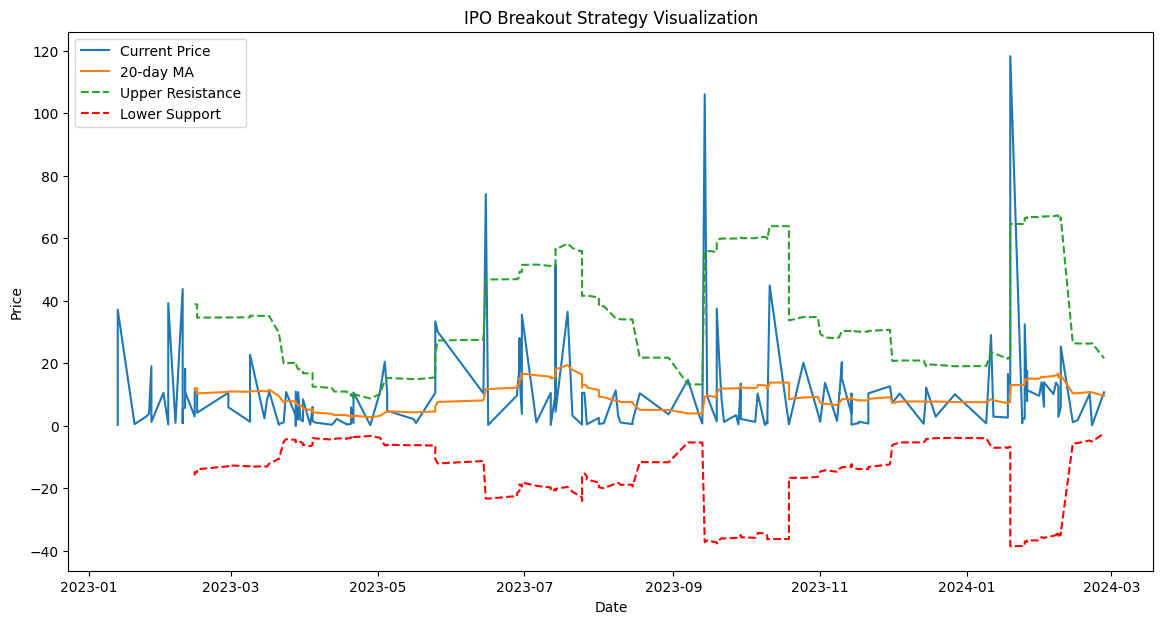

Buy Signals and Profit/Loss:
      IPO Date Symbol  Current  Sell Price  Profit/Loss
160 2023-04-28   TRNR     0.16        0.61         0.45
158 2023-05-04   KVUE    20.45       10.50        -9.95
157 2023-05-05   ALCY    10.64       10.50        -0.14
151 2023-05-26   ATMU    30.06        0.76       -29.30
150 2023-06-14   ESHA    10.36       11.30         0.94
147 2023-06-16    BOF     2.00        1.04        -0.96
112 2023-09-12   NWGL     2.61       20.38        17.77
109 2023-09-15   NMRA     9.42       10.27         0.85
62  2024-01-12   SYNX     2.90         NaN          NaN
57  2024-01-24     JL     0.79         NaN          NaN


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# First, convert IPO Date to datetime if not already
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'])

# Sort DataFrame by date to calculate rolling metrics
stacked_ipos_df.sort_values('IPO Date', inplace=True)

# Calculate the moving average and resistance for visualization and trading strategy
stacked_ipos_df['MA20'] = stacked_ipos_df['Current'].rolling(window=20).mean()
stacked_ipos_df['Upper Resistance'] = stacked_ipos_df['MA20'] + (2 * stacked_ipos_df['Current'].rolling(window=20).std())
stacked_ipos_df['Lower Support'] = stacked_ipos_df['MA20'] - (stacked_ipos_df['Current'].rolling(window=20).std() * 2)


# Plotting the current price and moving averages
plt.figure(figsize=(14, 7))
plt.plot(stacked_ipos_df['IPO Date'], stacked_ipos_df['Current'], label='Current Price')
plt.plot(stacked_ipos_df['IPO Date'], stacked_ipos_df['MA20'], label='20-day MA')
plt.plot(stacked_ipos_df['IPO Date'], stacked_ipos_df['Upper Resistance'], label='Upper Resistance', linestyle='--')
plt.plot(stacked_ipos_df['IPO Date'], stacked_ipos_df['Lower Support'], label='Lower Support', linestyle='--', color='red')
plt.title('IPO Breakout Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Identifying a breakout where the current price crosses above the upper resistance
stacked_ipos_df['Buy Signal'] = (stacked_ipos_df['Current'] > stacked_ipos_df['Upper Resistance']).shift(1)

# Assume we sell after a fixed period or at the end of available data
# For simplicity, let's say we sell after 30 days or the last available price
sell_prices = stacked_ipos_df['Current'].shift(-30)  # This needs real data to work properly
stacked_ipos_df['Sell Price'] = sell_prices

# Calculate profit or loss
stacked_ipos_df['Profit/Loss'] = np.where(stacked_ipos_df['Buy Signal'], (stacked_ipos_df['Sell Price'] - stacked_ipos_df['Current']), 0)

# Print potential buy signals and profit/loss
buy_signals = stacked_ipos_df[stacked_ipos_df['Buy Signal'] == True]
print("Buy Signals and Profit/Loss:")
print(buy_signals[['IPO Date', 'Symbol', 'Current', 'Sell Price', 'Profit/Loss']])

# Fill NaN sell prices with the last available price for simplicity
stacked_ipos_df['Sell Price'].fillna(stacked_ipos_df['Current'], inplace=True)
